In [1]:
import pandas as pd
from dython.nominal import associations
from sklearn.cluster import DBSCAN

from gower.gower_dist import *

# Simple example from D'Orazio

In [2]:
df = pd.DataFrame({"Sex1": ["M", "M", "F", "F", "F", "M", "M", "F", "F", "F"],
                   "Sex2": ["M", "M", "F", "F", "F", "F", "F", "M", "M", "M"],
                   "Age1": [15] * 10,
                   "Age2": [15, 36, 58, 78, 100, 15, 36, 58, 78, 100]})

In [3]:
distances = np.diag(gower_matrix(df[["Sex1", "Age1"]].to_numpy(), df[["Sex2", "Age2"]].to_numpy(), weight_cat="uniform"))
print(distances)
df.loc[np.argsort(distances)]

  0%|          | 0/1 [00:00<?, ?it/s]

[1.] [2.38552791]


  0%|          | 0/10 [00:00<?, ?it/s]

[0.         0.17408385 0.3564574  0.52225154 0.70462509 0.29537491
 0.46945876 0.65183231 0.81762645 1.        ]


,Sex1,Sex2,Age1,Age2
0,M,M,15,15
1,M,M,15,36
5,M,F,15,15
2,F,F,15,58
6,M,F,15,36
3,F,F,15,78
7,F,M,15,58
4,F,F,15,100
8,F,M,15,78
9,F,M,15,100


# Metrics

### We can also use the categorical weight function to measure cluster quality and thereby tune clustering algorithms such as DBSCAN.

##### I calculated Gower distances for each of the four datasets above using the new weighting scheme, and then ran a grid search with DBSCAN based on the new weighting formula for categorical variables.

# Istanbul dataset

  0%|          | 0/4 [00:00<?, ?it/s]

[1. 1. 1. 1.] [4.93182563 2.38629436 3.48114226 2.21985993]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

({'eps': 0.05, 'min_samples': 1}, 0.8643978869116461)
(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  28,
        29,  30,  31,  32,  34,  36,  37,  38,  39,  41,  44,  48,  50,
        53,  57,  59,  61,  62,  63,  65,  69,  71,  72,  75,  77,  78,
        80,  81,  87,  89,  91,  94,  99, 103, 134, 137, 138, 154, 189,
       203]), array([1614,  567,  257,  128,   71,   46,   33,   22,   20,   16,   10,
         15,    4,    9,    5,    5,    3,    3,    2,    2,    3,    4,
          1,    2,    1,    2,    1,    1,    1,    1,    1,    2,    2,
          1,    2,    1,    1,    2,    1,    1,    1,    2,    1,    1,
          1,    1,    2,    2,    1,    1,    1,    1,    1,    1,    2,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1]))


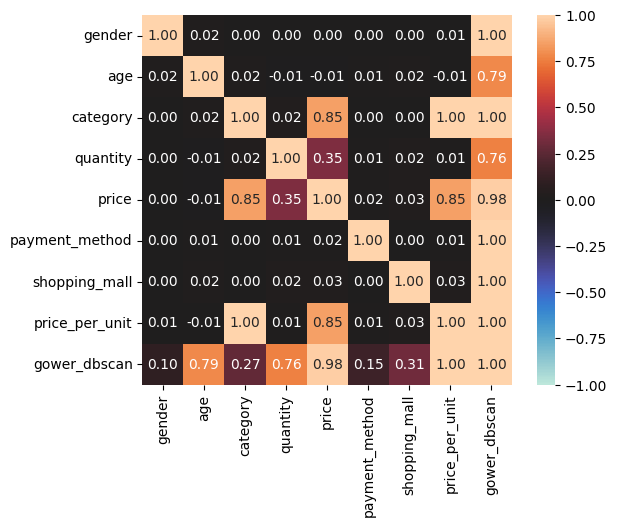

,gender,age,category,quantity,price,payment_method,shopping_mall,price_per_unit,gower_dbscan,label_count
65992,Female,53,Clothing,3,900.24,Cash,Kanyon,300.08,41,203
1514,Female,34,Clothing,1,300.08,Cash,Kanyon,300.08,41,203
87290,Female,63,Clothing,1,300.08,Cash,Kanyon,300.08,41,203
23436,Female,33,Clothing,4,1200.32,Cash,Kanyon,300.08,41,203
46834,Female,22,Clothing,3,900.24,Cash,Kanyon,300.08,41,203
...,...,...,...,...,...,...,...,...,...,...
3593,Male,67,Shoes,5,3000.85,Credit Card,Istinye Park,600.17,98,1
32980,Male,26,Souvenir,3,35.19,Credit Card,Viaport Outlet,11.73,994,1
21131,Female,23,Books,1,15.15,Debit Card,Emaar Square Mall,15.15,995,1
98676,Male,56,Technology,4,4200.00,Cash,Cevahir AVM,1050.00,996,1


In [4]:
istanbul = pd.read_csv("customer_shopping_data.csv").sample(n=10000, random_state=0).iloc[:, 2:]  # no nulls!
istanbul["price_per_unit"] = istanbul["price"] / istanbul["quantity"]
istanbul.drop("invoice_date", axis=1, inplace=True)

matrix4 = gower_matrix(istanbul.to_numpy(), weight_cat="uniform", chunksize=20)

samples = [{"eps": z / 100, "min_samples": 1} for z in range(1, 101)]

results4 = process_map(partial(evaluate_clusters, matrix=matrix4), samples, chunksize=1)

best_params4 = max(results4, key=lambda z: z[1])

print(best_params4)

istanbul["gower_dbscan"] = DBSCAN(metric="precomputed", **best_params4[0]).fit_predict(matrix4)
istanbul.gower_dbscan = istanbul.gower_dbscan.astype(str)

_, counts4 = np.unique(istanbul["gower_dbscan"], return_counts=True)

print(np.unique(counts4, return_counts=True))

associations(istanbul, nom_nom_assoc="theil", plot=True)

istanbul["label_count"] = istanbul.groupby("gower_dbscan").transform("count").iloc[:, 0]

istanbul.sort_values(["label_count", "gower_dbscan"], ascending=[False, True], inplace=True)

istanbul


# Laptops dataset

(977, 12)
Model Name                  488
Category                      6
Screen Size                  18
Screen                       38
CPU                         106
RAM                           8
 Storage                     36
GPU                          98
Operating System              7
Operating System Version      5
Weight                      166
Price                       639
dtype: int64


  0%|          | 0/1 [00:00<?, ?it/s]

[1. 1. 1. 1. 1. 1. 1. 1. 1.] [5.56252241]


  0%|          | 0/977 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

({'eps': 0.139, 'min_samples': 1}, 0.6404162695004346)
(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  15,  21,  30,  40,
       171]), array([422,  61,  13,   6,   3,   4,   3,   3,   1,   1,   1,   1,   1,
         1]))


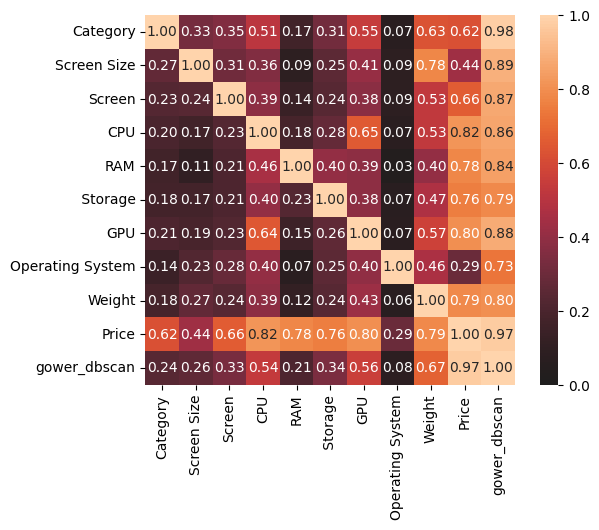

,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Weight,Price,gower_dbscan,label_count
Manufacturer,,,,,,,,,,,,
HP,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,5112900.00,2,171
Acer,Notebook,"15.6""",1366x768,AMD A9-Series 9420 3GHz,4GB,500GB HDD,AMD Radeon R5,Windows,2.1kg,3556800.00,2,171
HP,Notebook,"15.6""",Full HD 1920x1080,Intel Core i3 6006U 2GHz,4GB,500GB HDD,Intel HD Graphics 520,No OS,1.86kg,3067651.08,2,171
Dell,Notebook,"15.6""",Full HD 1920x1080,Intel Core i3 6006U 2GHz,4GB,256GB SSD,AMD Radeon R5 M430,Windows,2.2kg,4436218.80,2,171
Dell,Notebook,"15.6""",1366x768,Intel Core i3 6006U 2GHz,4GB,1TB HDD,Intel HD Graphics 520,Windows,2.3kg,3722546.88,2,171
...,...,...,...,...,...,...,...,...,...,...,...,...
Asus,Ultrabook,"14.0""",Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,8GB,256GB SSD,Intel UHD Graphics 620,Windows,1.25kg,9772308.00,94,1
HP,Ultrabook,"12.5""",IPS Panel 4K Ultra HD / Touchscreen 3840x2160,Intel Core M 6Y75 1.2GHz,8GB,512GB SSD,Intel HD Graphics 515,Windows,0.97kg,17908488.00,95,1
Dell,Gaming,"15.6""",Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD,Nvidia GeForce GTX 1050,Windows,2.56kg,11108419.92,97,1


In [5]:
laptops = pd.read_csv("laptops/laptops_train.csv", index_col=0)
print(laptops.shape)
print(laptops.apply(lambda col: col.unique(), axis=0).apply(len))
laptops.drop(["Operating System Version", "Model Name"], axis=1, inplace=True)

matrix3 = gower_matrix(laptops.to_numpy(), weight_cat="uniform", chunksize=20)
samples = [{"eps": z / 1000, "min_samples": 1} for z in range(1, 1001)]
results3 = process_map(partial(evaluate_clusters, matrix=matrix3), samples, chunksize=20)
best_params3 = max(results3, key=lambda z: z[1])
print(best_params3)
laptops["gower_dbscan"] = DBSCAN(metric="precomputed", **best_params3[0]).fit_predict(matrix3)
laptops.gower_dbscan = laptops.gower_dbscan.astype(str)
_, counts3 = np.unique(laptops["gower_dbscan"], return_counts=True)
print(np.unique(counts3, return_counts=True))

associations(laptops, nom_nom_assoc="theil", plot=True)

laptops["label_count"] = laptops.groupby("gower_dbscan").transform("count").iloc[:, 0]
laptops.sort_values(["label_count", "gower_dbscan"], ascending=[False, True], inplace=True)

laptops


# Pokemon dataset

  0%|          | 0/12 [00:00<?, ?it/s]

[1. 1. 1. 1. 1. 1. 1. 1. 1.] [5.57126785 4.659814   5.34436533 5.00478207 5.29629323 4.6100858
 5.31898999 2.60943791 2.73286795 3.8288446  4.61876915 4.33115688]


  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

({'eps': 0.09, 'min_samples': 1}, 0.5777523435668531)
(array([  1,   2,   3,   4,   5,   6,   7,   8,  10, 250]), array([317,  37,  10,   1,   3,   1,   1,   1,   1,   1]))


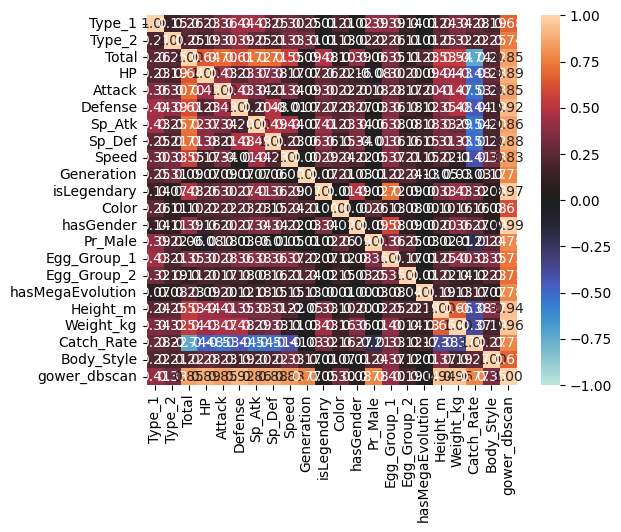

,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,...,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style,gower_dbscan,label_count
0,Grass,Poison,318,45,49,49,65,65,45,1,...,0.875,Monster,Grass,False,0.71,6.9,45,quadruped,0,250
1,Grass,Poison,405,60,62,63,80,80,60,1,...,0.875,Monster,Grass,False,0.99,13.0,45,quadruped,0,250
2,Grass,Poison,525,80,82,83,100,100,80,1,...,0.875,Monster,Grass,True,2.01,100.0,45,quadruped,0,250
3,Fire,none,309,39,52,43,60,50,65,1,...,0.875,Monster,Dragon,False,0.61,8.5,45,bipedal_tailed,0,250
4,Fire,none,405,58,64,58,80,65,80,1,...,0.875,Monster,Dragon,False,1.09,19.0,45,bipedal_tailed,0,250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,Bug,Steel,465,75,90,140,60,60,40,2,...,0.500,Bug,none,False,1.19,125.8,75,head_only,94,1
205,Normal,none,415,100,70,70,65,65,45,2,...,0.500,Field,none,False,1.50,14.0,190,serpentine_body,95,1
207,Steel,Ground,510,75,85,200,55,65,30,2,...,0.500,Mineral,none,True,9.19,400.0,25,serpentine_body,97,1
208,Fairy,none,300,60,80,50,40,40,30,2,...,0.250,Field,Fairy,False,0.61,7.8,190,bipedal_tailless,98,1


In [6]:
pokemon = pd.read_csv("pokemon/pokemon_alopez247.csv").iloc[:, 2:]
for c in pokemon.columns[pokemon.dtypes != object]:
    pokemon.loc[pokemon[c].isna(), c] = np.nanmedian(pokemon[c])
for c in pokemon.columns[pokemon.dtypes == object]:
    pokemon.loc[pokemon[c].isna(), c] = "none"

matrix2 = gower_matrix(pokemon.to_numpy(), weight_cat="uniform", chunksize=20)
samples = [{"eps": z / 100, "min_samples": 1} for z in range(1, 1001)]
results2 = process_map(partial(evaluate_clusters, matrix=matrix2), samples, chunksize=20)
best_params2 = max(results2, key=lambda z: z[1])
print(best_params2)
pokemon["gower_dbscan"] = DBSCAN(metric="precomputed", **best_params2[0]).fit_predict(matrix2)
pokemon.gower_dbscan = pokemon.gower_dbscan.astype(str)
_, counts2 = np.unique(pokemon["gower_dbscan"], return_counts=True)
print(np.unique(counts2, return_counts=True))

associations(pokemon, nom_nom_assoc="theil", plot=True)

pokemon["label_count"] = pokemon.groupby("gower_dbscan").transform("count").iloc[:, 0]
pokemon.sort_values(["label_count", "gower_dbscan"], ascending=[False, True], inplace=True)

pokemon
